Dog Vs Cat an Image classifier.
Full run through of raw images to classification with Convolutional Neural Network¶
In this notebook I am going to be running through taking raw images that have been labeled for us already, and then feeding them through a convolutional neural network for classification.

The images are either of dog(s) or cat(s).

Once you have downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data, you're ready to begin.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from random import shuffle
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from tqdm import tqdm
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'test']


In [2]:
TRAIN_DIR = "../input/train" #Reading in the training directory.
#TEST_DIR = "../input/test"
IMG_SIZE = 100

Now, the first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array.

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:


In [3]:
def get_label(img):                      #Function to get the label of the image, is it a cat or a dog.
    word_label = img.split('.')[0] 
    if word_label == 'cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]     #Return the respective label.

Now, I build another function to fully process the training images and their labels into arrays and return the array:



In [4]:
def create_train_data():                  #Function for creation of the training data
    train_data = []
    for img in (os.listdir(TRAIN_DIR)):        #For each image repeat.
        label = get_label(img)                 #Get the image label.
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))  #Resizing the image
        train_data.append([np.array(img),np.array(label)])
    shuffle(train_data)
    return train_data

Here we call the create train data function to load all the images in the array.

In [5]:
train_data = create_train_data()

In [6]:
print(len(train_data))

25000


Next, we're ready to define our neural network:

In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2,activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024,activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet,2,activation='softmax')
convnet = regression(convnet,optimizer = 'adam', loss='categorical_crossentropy',name='conv_NN')

model = tflearn.DNN(convnet)

Now, let's split out training and validation data, we use 24.500 images for training and 500 images for validation.



In [8]:
train = train_data[:-500]
test = train_data[-500:]

Now, the training data and testing data are both labeled datasets. The training data is what we'll fit the neural network with, and the test data is what we're going to use to validate the results. The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it.


Next, I am going to create our data arrays. For some reason, typical numpy logic like:

array[:,0] and array[:,1] did NOT work for me here. Not sure what I'm doing wrong, so I do this instead to separate my features and labels:

In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE,1) 
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE,1) 
test_y = [i[1] for i in test]

Now we fit for 5 epochs:



In [10]:
model.fit(X,Y, n_epoch= 5,validation_set=(test_x,test_y),snapshot_step=500,show_metric=True,run_id='ConvNN')

Training Step: 1914  | total loss: 0.47820 | time: 189.919s
| Adam | epoch: 005 | loss: 0.47820 - acc: 0.7503 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.47592 | time: 191.425s
| Adam | epoch: 005 | loss: 0.47592 - acc: 0.7565 | val_loss: 0.54792 - val_acc: 0.7420 -- iter: 24500/24500
--


Here, I check the results by loading some images and printing their predictions.

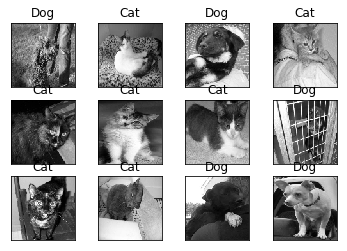

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()

for num, data in enumerate(test[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if( np.argmax(model_out) == 1):
        str_label = 'Dog'
    else:
        str_label = 'Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    
    